In [192]:
import numpy as np
from numpy import size
import h5py
import matplotlib.pyplot as plt

In [ ]:
def load_data(filename, is_train=True):
    with h5py.File(filename, 'r') as hdf:
        # Determine key prefixes
        prefix = 'train' if is_train else 'test'
        
        X = np.array(hdf[f'{prefix}_set_x'][:], dtype=np.float64)
        Y = np.array(hdf[f'{prefix}_set_y'][:], dtype=np.float64)
    
    # Reshape and normalize
    X = X.reshape(-1, 64*64*3).T / 255.0
    X = np.vstack((X, np.ones((1, X.shape[1]))))  # Add bias
    Y = Y.reshape(1, -1)
    
    return X, Y

# Load datasets CORRECTLY
train_set_x_flatten, train_set_y = load_data('datasets/train_catvnoncat.h5', is_train=True)
test_set_x_flatten, test_set_y = load_data('datasets/test_catvnoncat.h5', is_train=False)

In [194]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))


def isok(a,idx):
    return bool(bool(a>0.5)==(train_set_y[0][idx].astype(bool)))

def calculate_accuracy_2(A,Y):
    predictions = (A > 0.50).astype(float)           #vector operations accelerate convergence
    return np.mean(predictions == Y)

In [195]:
print(train_set_x_flatten.shape[1])
weight_matrix = np.zeros((train_set_x_flatten.shape[0],1))

209


In [196]:
acc_vec = []
loss_vec = []
test_vec = []

weight_matrix = np.zeros((train_set_x_flatten.shape[0],1))


def train_model(weight_matrix, train_set_x_flatten, train_set_y,acc_target, alpha, max_iterations=10000):
    step_number = 0
    accuracy = 0

    while accuracy < acc_target and step_number < max_iterations:
        Z = np.dot(weight_matrix.T, train_set_x_flatten)
        A = sigmoid(Z)

        dw = -alpha *(1 / train_set_x_flatten.shape[1])* np.dot(train_set_x_flatten, (A - train_set_y).T)

        # Update weights as specified
        weight_matrix = weight_matrix + dw

        loss = -np.mean(train_set_y * np.log(A + 1e-9) + (1 - train_set_y) * np.log(1 - A + 1e-9))
        loss_vec.append(loss)

        accuracy = calculate_accuracy_2(A, train_set_y)
        step_number += 1
        acc_vec.append(accuracy)

        Z_test = np.dot(weight_matrix.T, test_set_x_flatten)
        A_test = sigmoid(Z_test)

        acc_test = calculate_accuracy_2(A_test,test_set_y)
        test_vec.append(acc_test)


    return weight_matrix

print(train_set_x_flatten.shape[0])


12289


[np.float64(0.34), np.float64(0.66), np.float64(0.34), np.float64(0.66), np.float64(0.34), np.float64(0.66), np.float64(0.34), np.float64(0.68), np.float64(0.34), np.float64(0.7), np.float64(0.34), np.float64(0.7), np.float64(0.34), np.float64(0.72), np.float64(0.34), np.float64(0.74), np.float64(0.34), np.float64(0.72), np.float64(0.34), np.float64(0.74), np.float64(0.34), np.float64(0.76), np.float64(0.34), np.float64(0.78), np.float64(0.34), np.float64(0.78), np.float64(0.34), np.float64(0.78), np.float64(0.34), np.float64(0.78), np.float64(0.34), np.float64(0.78), np.float64(0.34), np.float64(0.78), np.float64(0.34), np.float64(0.78), np.float64(0.34), np.float64(0.8), np.float64(0.34), np.float64(0.8), np.float64(0.34), np.float64(0.8), np.float64(0.34), np.float64(0.8), np.float64(0.34), np.float64(0.8), np.float64(0.34), np.float64(0.8), np.float64(0.34), np.float64(0.8), np.float64(0.34), np.float64(0.82), np.float64(0.34), np.float64(0.82), np.float64(0.34), np.float64(0.82), 

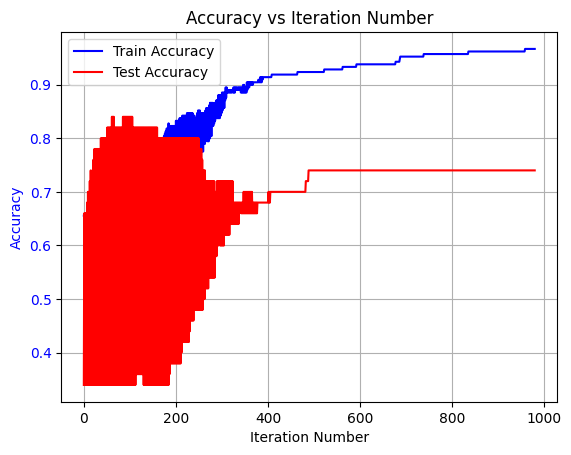

In [197]:
acc_vec = []
loss_vec = []
test_vec = []

weight_matrix = train_model(weight_matrix,train_set_x_flatten,train_set_y,0.99,0.005,980)
Z_test = np.dot(weight_matrix.T, test_set_x_flatten)
A_test = sigmoid(Z_test)

acc_test = calculate_accuracy_2(A_test,test_set_y)
print(test_vec)
print(acc_test)

plt.figure()
ax1 = plt.gca()
ax1.plot(range(len(acc_vec)), acc_vec, 'b', label='Train Accuracy')
ax1.plot(range(len(test_vec)), test_vec, 'r', label='Test Accuracy')

ax1.set_xlabel('Iteration Number')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')


plt.title('Accuracy vs Iteration Number')
plt.grid(True)
plt.show()

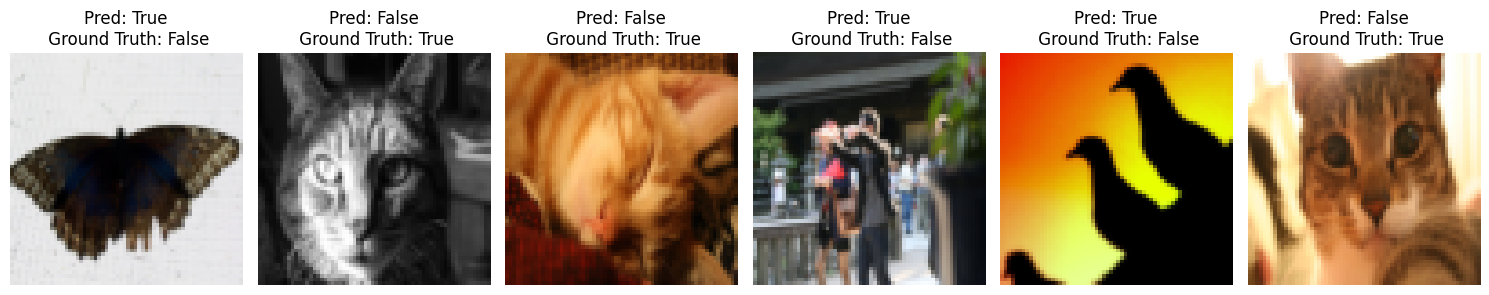

In [ ]:
def show_errors(X, y, pred, n=5):
    # Find all wrong predictions
    wrong = np.where(pred != y)[1]
    
    # Pick random errors
    show_n = min(n, len(wrong))
    random_errors = np.random.choice(wrong, show_n, replace=False)
    
    # Setup plot
    plt.figure(figsize=(15, 3))
    
    for i, idx in enumerate(random_errors):
        # Get image data (remove bias unit, reshape, convert to 0-255)
        img = X[:-1, idx].reshape(64, 64, 3) * 255
        img = img.astype(np.uint8)
        
        # Create subplot
        plt.subplot(1, show_n, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {pred[0,idx]}\n Ground Truth: {bool(y[0,idx])}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

test_pred = (sigmoid(np.dot(weight_matrix.T, test_set_x_flatten)) > 0.5)

show_errors(test_set_x_flatten, test_set_y, test_pred, 6)

# Translating weights to conductances

In [199]:
def conductance_calc(w, Gmax=110E-6):

    max_w = np.max(np.abs(w))
    scale_factor = Gmax / max_w
    
    Gplus  = (w > 0) * (w * scale_factor)
    Gminus = (w < 0) * (-w * scale_factor)

    if(np.max(Gplus) > Gmax):
        print("error: Conductance above physical maximum")
        print("Gplus", np.max(Gplus)*1e6)
    
    if(np.max(Gminus) > Gmax):
        print("error: Conductance above physical maximum")
        print("Gminus",np.max(Gminus)*1e6)
    
    return Gplus.T, Gminus.T

def memres_inf(x, Gplus, Gminus):
    I_out  = np.dot((Gplus-Gminus),x)
    
    A = 1.0/(1.0 + np.exp(-I_out))
    return A    

In [200]:
Gplus_noise_free, Gminus_noise_free = conductance_calc(weight_matrix, Gmax=110E-6)


A_out = memres_inf(test_set_x_flatten, Gplus_noise_free, Gminus_noise_free)

print(calculate_accuracy_2(A_out,test_set_y))

0.74


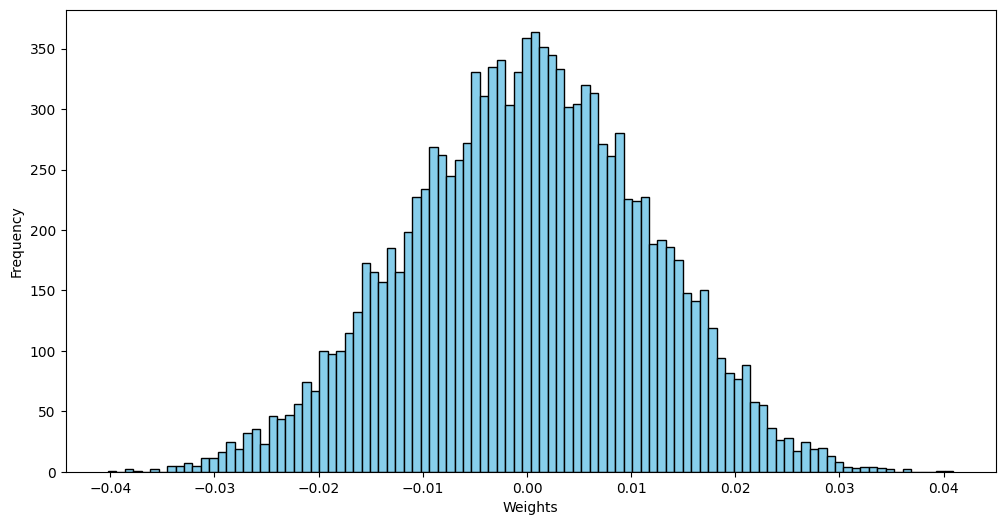

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(weight_matrix, bins=100, color='skyblue', edgecolor='black')

plt.xlabel('Weights')
plt.ylabel('Frequency')
 
plt.show()

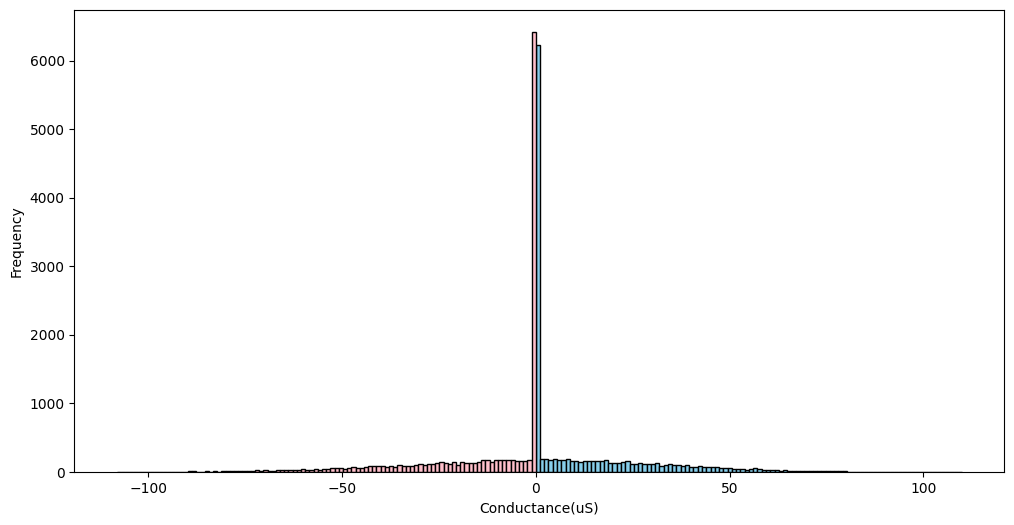

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(Gplus_noise_free[0]*1e6, bins=100, color='skyblue', edgecolor='black')
plt.hist(Gminus_noise_free[0]*-1*1e6, bins=100, color='pink', edgecolor='black')

plt.xlabel('Conductance(uS)')
plt.ylabel('Frequency')
 
plt.show()

# Adding noise

In [203]:
def noise_adding(sigma,Gplus,Gminus):
    Gplus_cpy = np.copy(Gplus)
    Gminus_cpy = np.copy(Gminus)
    
    Gplus_cpy, Gminus_cpy = (Gplus > 0) * (Gplus + np.random.normal(0,sigma,Gplus.shape)), (Gminus > 0) * (Gminus + np.random.normal(0,sigma,Gplus.shape))
    
    return  np.clip(Gplus_cpy,  0, 110E-6),np.clip(Gminus_cpy,  0, 110E-6)

## Finding max noise:

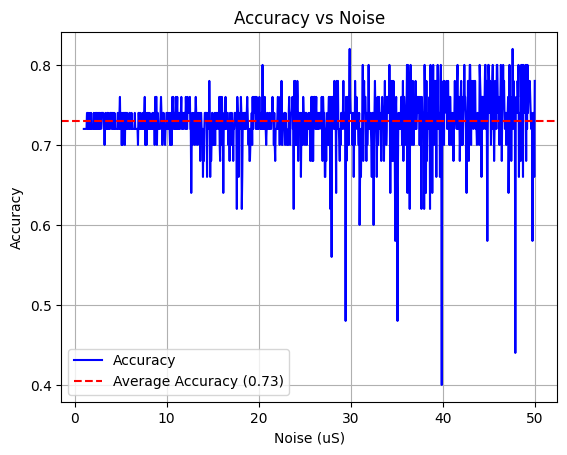

In [204]:
#Gplus_noise_free, Gminus_noise_free = conductance_calc(weight_matrix, Gmax=110e-6)

noise_vec = np.linspace(1E-6, 50E-6, int(1000))  # Avoid incrementing sigma manually (gpt orientation to accelerate method)
acc_vec = np.zeros(len(noise_vec))              #GPT suggestion (leaves a memory space created, accelerating)

for i in range(len(noise_vec)):
    # sigma += 1E-12 too slow to do this this way
    
   Gplus_noisy, Gminus_noisy = noise_adding(noise_vec[i],Gplus_noise_free,Gminus_noise_free)
   A_out = memres_inf(test_set_x_flatten, Gplus_noisy, Gminus_noisy)
   acc_vec[i] = (calculate_accuracy_2(A_out,test_set_y))


plt.plot(noise_vec*1e6, acc_vec, linestyle='-', color='b', label='Accuracy')
avg_acc = np.mean(acc_vec)
plt.axhline(avg_acc, color='r', linestyle='--', label=f'Average Accuracy ({avg_acc:.2f})')
plt.xlabel('Noise (uS)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Noise')  
plt.legend()
plt.grid(True)
plt.show() 


# Hardware-aware(iterative)

<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\gudua\AppData\Local\Temp\ipykernel_9252\3384667779.py:28: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("$\sigma$ (µS)")


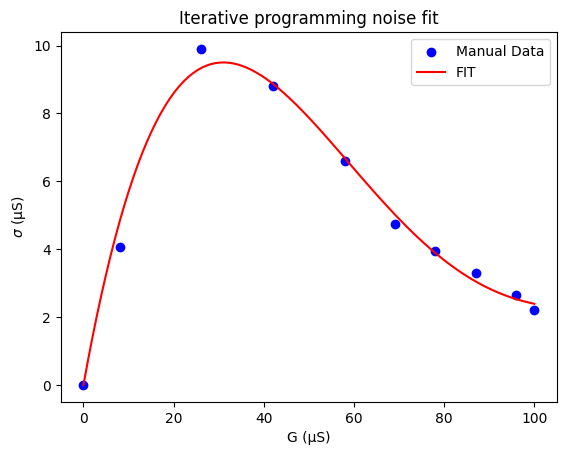

0.0


In [ ]:
x = [0,8,26,42,58,69,78,87,96,100]
y = [0,3.7,9,8,6,4.3,3.6,3,2.4,2]

#x = [0,8,16,26,42,58,69,78,87,96,100]
#y = [16,12.5,11,9,8,6,4.3,3.6,3,2.4,2]


x = np.multiply(x, 1E-6)
y = np.multiply(y, 1E-6)
y = np.multiply(y, 1.1)

#GPT suggestion to fix problem with negative Y values(which breaks the random noise generation)
# Fit polynomial without constant term (y = a x^4 + b x^3 + c x^2 + d x)
A = np.column_stack([x**4, x**3, x**2, x]) 
coeffs, _, _, _ = np.linalg.lstsq(A, y, rcond=None)


# Create polynomial function with a zero constant term
poly_coeffs = np.concatenate([coeffs, [0]])  # Adds the 0 coefficient for x^0
poly_func = np.poly1d(poly_coeffs)

x_fit = np.linspace(np.min(x),np.max(x),size(x)*10)
y_fit = poly_func(x_fit)

plt.scatter(x*1E6, y*1E6, color='blue', label='Manual Data')
plt.plot(x_fit*1E6, y_fit*1E6, color='red', label=f'FIT')
plt.title('Iterative programming noise fit')
plt.xlabel("G (µS)")
plt.ylabel("$\sigma$ (µS)")
plt.legend()
plt.show()

In [215]:
def noise_adding_fit(Gplus, Gminus):
    Gplus_copy = np.copy(Gplus)
    Gminus_copy = np.copy(Gminus)
    
    for i in range(Gplus_copy.shape[1]):
        Gplus_copy[0][i] = Gplus_copy[0][i] + np.random.normal(0, poly_func(Gplus_copy[0][i]))
        Gminus_copy[0][i] = Gminus_copy[0][i] + np.random.normal(0, poly_func(Gminus_copy[0][i]))
    
    return Gplus_copy, Gminus_copy

In [216]:
acc_iterative = []
for i in range(100):

    Gplus_noisy_fit, Gminus_noisy_fit = noise_adding_fit(Gplus_noise_free,Gminus_noise_free)

    Gplus_noisy_fit = np.clip(Gplus_noisy_fit,0,110e-6)
    Gminus_noisy_fit = np.clip(Gminus_noisy_fit,0,110e-6)
    A_out_fit = memres_inf(test_set_x_flatten, Gplus_noisy_fit, Gminus_noisy_fit)

    if(i%100 == 0): 
        print("Step:",i)
        
    acc_iterative.append(calculate_accuracy_2(A_out_fit,test_set_y))


Step: 0


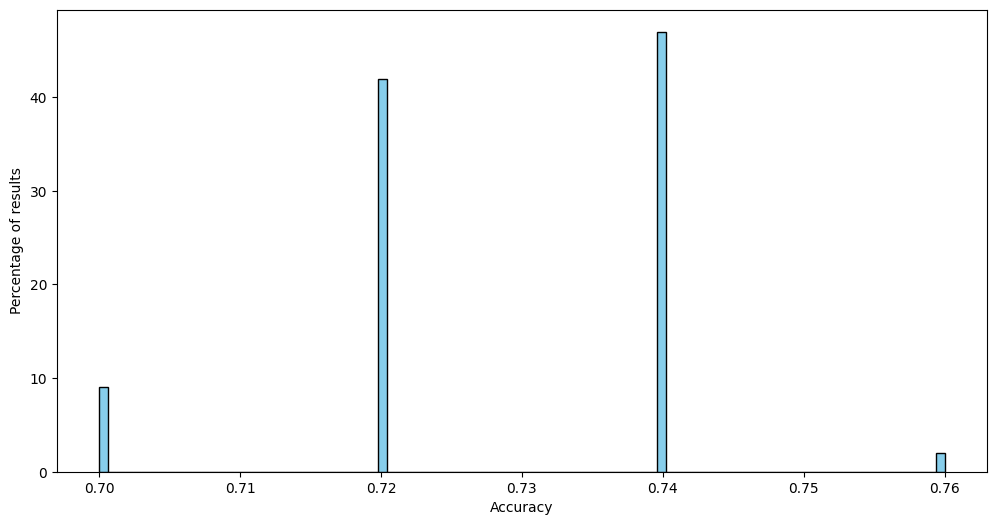

In [217]:
plt.figure(figsize=(12, 6))
plt.hist(acc_iterative, bins=100, color='skyblue', edgecolor='black',density = False)

plt.xlabel('Accuracy')
plt.ylabel('Percentage of results')
 
# Display the plot
plt.show()

# Hardware aware(one-shot)

<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\gudua\AppData\Local\Temp\ipykernel_9252\3076652751.py:28: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("$\sigma$ (µS)")


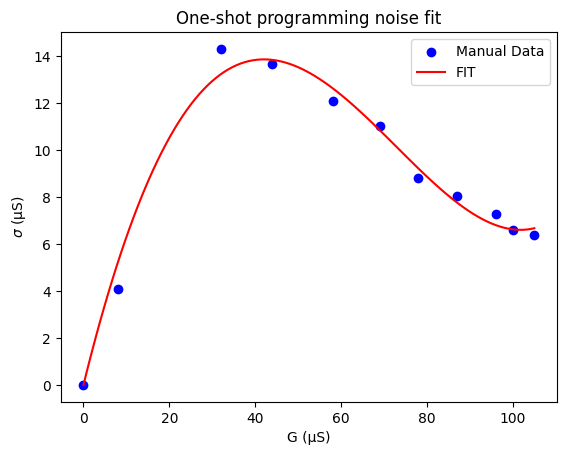

0.0


In [ ]:
x = [0,8,32,44,58,69, 78 ,87 ,96 ,100,105]
y = [0,3.7,13,12.4,11,10 ,8 ,7.3 ,6.6 ,6,5.8]

#x = [0,8,16,26,42,58,69,78,87,96,100]
#y = [16,12.5,11,9,8,6,4.3,3.6,3,2.4,2]


x = np.multiply(x, 1E-6)
y = np.multiply(y, 1E-6)
y = np.multiply(y, 1.1)

# Fit polynomial without constant term (y = a x^4 + b x^3 + c x^2 + d x)
A = np.column_stack([x**4, x**3, x**2, x])  # Design matrix
coeffs, _, _, _ = np.linalg.lstsq(A, y, rcond=None)


poly_coeffs = np.concatenate([coeffs, [0]])  # Adds the 0 coefficient for x^0
poly_func = np.poly1d(poly_coeffs)

x_fit = np.linspace(np.min(x),np.max(x),size(x)*10)
y_fit = poly_func(x_fit)

plt.scatter(x*1E6, y*1E6, color='blue', label='Manual Data')
plt.plot(x_fit*1E6, y_fit*1E6, color='red', label=f'FIT')
plt.title("One-shot programming noise fit")
plt.xlabel("G (µS)")
plt.ylabel("$\sigma$ (µS)")
plt.legend()
plt.show()
print(poly_func(0))

In [220]:
acc_one_shot = []
for i in range(100):

    Gplus_noisy_fit, Gminus_noisy_fit = noise_adding_fit(Gplus_noise_free,Gminus_noise_free)

    Gplus_noisy_fit = np.clip(Gplus_noisy_fit,0,110e-6)
    Gminus_noisy_fit = np.clip(Gminus_noisy_fit,0,110e-6)
    A_out_fit = memres_inf(test_set_x_flatten, Gplus_noisy_fit, Gminus_noisy_fit)

    if(i%100 == 0): 
        print("Step:",i)
        
    acc_one_shot.append(calculate_accuracy_2(A_out_fit,test_set_y))


Step: 0


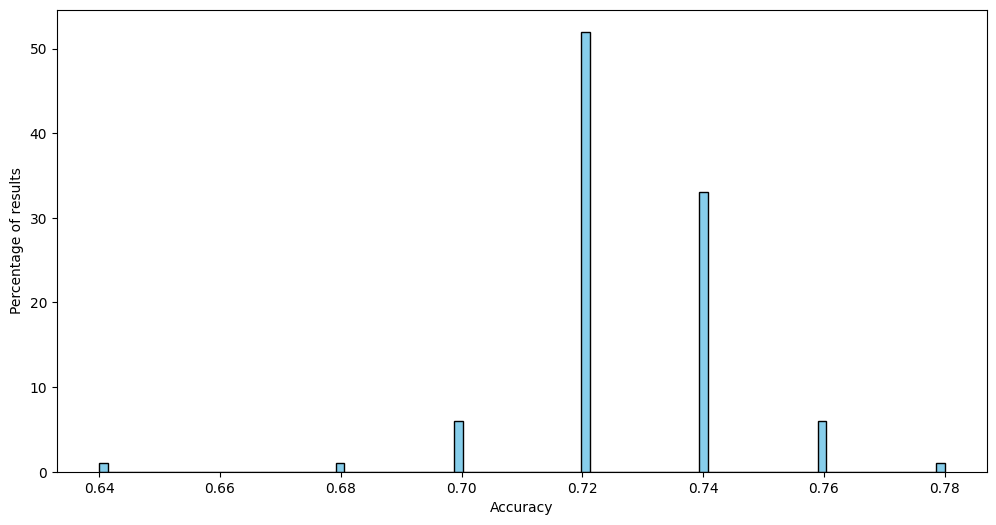

In [221]:
plt.figure(figsize=(12, 6))
plt.hist(acc_one_shot, bins=100, color='skyblue', edgecolor='black',density = False)

plt.xlabel('Accuracy')
plt.ylabel('Percentage of results')
 
# Display the plot
plt.show()

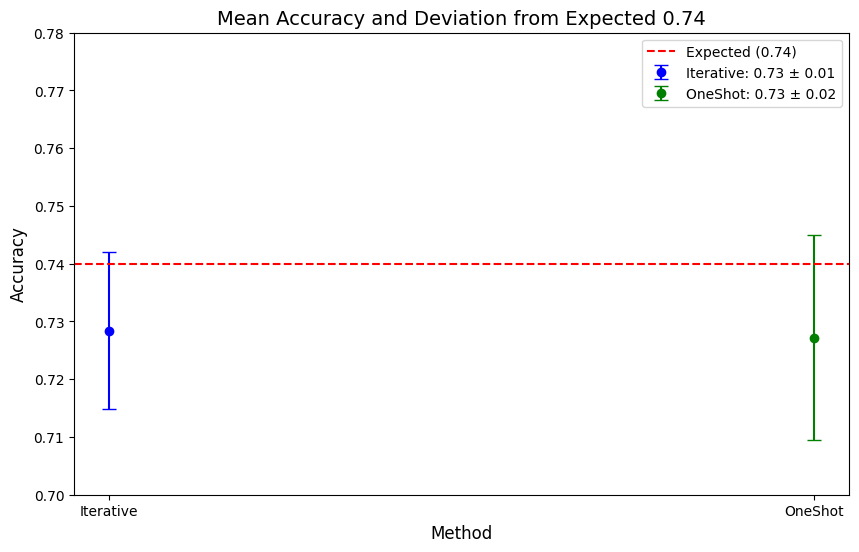

In [222]:
# Assuming acc_iterative is your data
mean_acc = np.mean(acc_iterative)
std_acc = np.std(acc_iterative)

mean_acc_oneshot = np.mean(acc_one_shot)
std_acc_oneshot = np.std(acc_one_shot)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the mean with error bars (using standard deviation)
# Use x-coordinates 0 and 1 for better spacing with labels
plt.errorbar(0, mean_acc, yerr=std_acc, fmt='o', color='blue', capsize=5, label=f'Iterative: {mean_acc:.2f} ± {std_acc:.2f}')
plt.errorbar(1, mean_acc_oneshot, yerr=std_acc_oneshot, fmt='o', color='green', capsize=5, label=f'OneShot: {mean_acc_oneshot:.2f} ± {std_acc_oneshot:.2f}')

# Add a reference line at the expected value (0.74)
plt.axhline(y=0.74, color='red', linestyle='--', label='Expected (0.74)')

# Customize the plot
plt.ylim(0.70, 0.78)  # Adjust based on your data range
plt.xlabel('Method', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Mean Accuracy and Deviation from Expected 0.74', fontsize=14)

# Set custom x-axis labels
plt.xticks([0, 1], ['Iterative', 'OneShot'])

# Add legend
plt.legend()

# Display the plot
plt.show()